# FDA Text Cleaning & Data Visualization Notebook


This notebook loads FDA regulation text files for Drugs, Medical Devices, and Biologics, performs cleaning, and saves outputs for analysis.

## Import Libraries

In [1]:
from pathlib import Path
import os
import glob
import pandas as pd
import sys, subprocess

import re
import unicodedata
from typing import List
import pandas as pd
from tqdm.auto import tqdm

subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])
from tqdm.auto import tqdm
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "pyarrow"])

0

## Import Data

In [2]:
# Setup and paths
BASE_DIR = Path("/Users/Kay Michnicki/AllCode/FDA Data Scraping")
TEXT_ROOT = BASE_DIR / "fda_output"
CATEGORIES = ["Drugs", "MedicalDevices", "Biologics"]
OUTPUT_DIR = BASE_DIR / "fda_output_cleaned"
OUTPUT_DIR.mkdir(exist_ok=True)

pd.set_option("display.max_colwidth", 200)
print("Base:", BASE_DIR)
print("Text root:", TEXT_ROOT)
print("Output:", OUTPUT_DIR)
import re
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])
from tqdm.auto import tqdm


Base: /Users/Kay Michnicki/AllCode/FDA Data Scraping
Text root: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output
Output: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output_cleaned


In [3]:
# Discover text files

def list_text_files():
    rows = []
    for cat in CATEGORIES:
        txt_dir = TEXT_ROOT / cat / "text"
        if not txt_dir.exists():
            continue
        for p in txt_dir.glob("*.txt"):
            rows.append({
                "category": cat,
                "file_path": str(p),
                "filename": p.name,
            })
    return pd.DataFrame(rows)

files_df = list_text_files()
print("Files found:", len(files_df))
files_df.head()


Files found: 1880


,category,file_path,filename
0,Drugs,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-239-KBPDF-239-KB-of-Certain-Ophthalmic-Products-Policy-Regarding-Compliance-With-21-CFR-Part-4-Guidance-for-Industry-Guidan...,PDF-239-KBPDF-239-KB-of-Certain-Ophthalmic-Products-Policy-Regarding-Compliance-With-21-CFR-Part-4-Guidance-for-Industry-Guidance-for-Industry_20251026_190614.txt
1,Drugs,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-21288-KBPDF-21288-KB-of-SUPAC-Manufacturing-Equipment-Addendum_20251026_191638.txt,PDF-21288-KBPDF-21288-KB-of-SUPAC-Manufacturing-Equipment-Addendum_20251026_191638.txt
2,Drugs,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-15726-KBPDF-15726-KB-of-Considerations-When-Transferring-Clinical-Investigation-Oversight-to-Another-IRB-Guidance-for-IRBs-...,PDF-15726-KBPDF-15726-KB-of-Considerations-When-Transferring-Clinical-Investigation-Oversight-to-Another-IRB-Guidance-for-IRBs-Clinical-Investigators-and-Sponsors_20251026_191705.txt
3,Drugs,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-9794-KBPDF-9794-KB-of-E18-Genomic-Sampling-and-Management-of-Genomic-Data-Guidance-for-Industry_20251026_191257.txt,PDF-9794-KBPDF-9794-KB-of-E18-Genomic-Sampling-and-Management-of-Genomic-Data-Guidance-for-Industry_20251026_191257.txt
4,Drugs,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-24089-KBPDF-24089-KB-of-Cross-Labeling-Oncology-Drugs-in-Combination-Regimens_20251026_190429.txt,PDF-24089-KBPDF-24089-KB-of-Cross-Labeling-Oncology-Drugs-in-Combination-Regimens_20251026_190429.txt


## Data Cleaning

In [4]:
# Cleaning utilities
from typing import List


tqdm.pandas()

URL_PAT = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
PAGE_NUM_PAT = re.compile(r"^\s*(page|p\.)\s*\d+(\s*/\s*\d+)?\s*$", re.IGNORECASE)
MULTI_WS_PAT = re.compile(r"[ \t]{2,}")
HARD_BREAK_HYPHEN = re.compile(r"-\n")
INLINE_HYPHEN_WRAP = re.compile(r"(\w)-\n(\w)")


def normalize_unicode(text: str):
    return unicodedata.normalize("NFKC", text)


def strip_headers_footers(lines: List[str]):
    cleaned = []
    for ln in lines:
        if PAGE_NUM_PAT.match(ln.strip()):
            continue
        cleaned.append(ln)
    return cleaned


def clean_text(raw: str):
    x = normalize_unicode(raw)
    x = INLINE_HYPHEN_WRAP.sub(r"\1\2", x)
    x = HARD_BREAK_HYPHEN.sub("", x)
    x = URL_PAT.sub(" ", x)

    lines = x.splitlines()
    lines = strip_headers_footers(lines)
    x = "\n".join(lines)

    x = MULTI_WS_PAT.sub(" ", x)
    x = re.sub(r"\n{3,}", "\n\n", x)
    x = x.strip()
    return x


def read_text(path: str):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()


def build_clean_dataframe(df: pd.DataFrame):
    df = df.copy()
    df["raw_text"] = df["file_path"].progress_apply(read_text)
    df["clean_text"] = df["raw_text"].progress_apply(clean_text)
    df["char_len"] = df["clean_text"].str.len()
    df["word_count"] = df["clean_text"].str.split().str.len()
    return df

clean_df = build_clean_dataframe(files_df)
clean_df[["category","filename","word_count","char_len"]].head()


  0%|          | 0/1880 [00:00<?, ?it/s]

  0%|          | 0/1880 [00:00<?, ?it/s]

,category,filename,word_count,char_len
0,Drugs,PDF-239-KBPDF-239-KB-of-Certain-Ophthalmic-Products-Policy-Regarding-Compliance-With-21-CFR-Part-4-Guidance-for-Industry-Guidance-for-Industry_20251026_190614.txt,2812,19347
1,Drugs,PDF-21288-KBPDF-21288-KB-of-SUPAC-Manufacturing-Equipment-Addendum_20251026_191638.txt,10725,63151
2,Drugs,PDF-15726-KBPDF-15726-KB-of-Considerations-When-Transferring-Clinical-Investigation-Oversight-to-Another-IRB-Guidance-for-IRBs-Clinical-Investigators-and-Sponsors_20251026_191705.txt,7425,48079
3,Drugs,PDF-9794-KBPDF-9794-KB-of-E18-Genomic-Sampling-and-Management-of-Genomic-Data-Guidance-for-Industry_20251026_191257.txt,5421,37538
4,Drugs,PDF-24089-KBPDF-24089-KB-of-Cross-Labeling-Oncology-Drugs-in-Combination-Regimens_20251026_190429.txt,2419,16427


In [5]:
# Save cleaned outputs
tqdm.pandas()

from pathlib import Path

parquet_path = OUTPUT_DIR / "fda_cleaned.parquet"
cols = ["category","filename","file_path","clean_text","word_count","char_len"]
clean_df[cols].to_parquet(parquet_path, index=False)
print("Saved:", parquet_path)

# Optional: also write cleaned .txt files mirroring structure
WRITE_CLEAN_TXT = False  # set True to enable

def write_clean_texts(df: pd.DataFrame, root: Path):
    for cat, grp in df.groupby("category"):
        out_dir = root / cat / "text"
        out_dir.mkdir(parents=True, exist_ok=True)
        for _, row in grp.iterrows():
            out_path = out_dir / row["filename"]
            with open(out_path, "w", encoding="utf-8") as f:
                f.write(row["clean_text"])

if WRITE_CLEAN_TXT:
    write_clean_texts(clean_df, OUTPUT_DIR)
    print("Clean text files written under:", OUTPUT_DIR)


Saved: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output_cleaned/fda_cleaned.parquet


In [6]:
# Verification and sampling
# Shortest docs
short_df = clean_df.sort_values("word_count").head(10)[["category","filename","word_count"]]
print(short_df)

# Sample a few cleaned texts
sample = clean_df.sample(min(3, len(clean_df)), random_state=42)
for _, r in sample.iterrows():
    print("===", r["category"], r["filename"]) 
    print(r["clean_text"][:1000], "\n")

            category  \
347            Drugs   
1857       Biologics   
1112  MedicalDevices   
1390  MedicalDevices   
146            Drugs   
1666       Biologics   
710            Drugs   
1076  MedicalDevices   
1326  MedicalDevices   
1072  MedicalDevices   

                                                                                                                                                         filename  \
347                                                         PDF-4285-KBPDF-4285-KB-of-Industry-Supported-Scientific-and-Educational-Activites_20251026_192513.txt   
1857                                                        PDF-4285-KBPDF-4285-KB-of-Industry-Supported-Scientific-and-Educational-Activites_20251026_185758.txt   
1112                                                        PDF-4285-KBPDF-4285-KB-of-Industry-Supported-Scientific-and-Educational-Activites_20251026_194148.txt   
1390                                 PDF-4285-KBPDF-4285-KB-of-Industry-Sup

## Data Visualization

In [7]:
# Visualization Setup
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Install wordcloud if needed
try:
    from wordcloud import WordCloud
    print("✓ wordcloud already installed")
except ImportError:
    import sys, subprocess
    print("Installing wordcloud...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud
    print("✓ wordcloud installed")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Create output directory for plots
PLOT_DIR = OUTPUT_DIR / "visualizations"
PLOT_DIR.mkdir(exist_ok=True)
print(f"Plot directory: {PLOT_DIR}")


Installing wordcloud...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 2.9 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


✓ wordcloud installed
Plot directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output_cleaned/visualizations


### Category Distribution


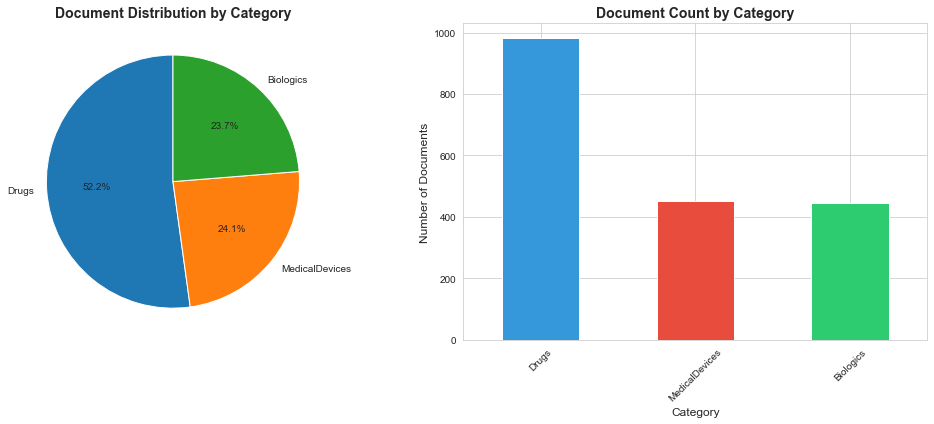


Category Statistics:
category
Drugs             981
MedicalDevices    453
Biologics         446
Name: count, dtype: int64

Total documents: 1,880


In [8]:
# Category Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
category_counts = clean_df['category'].value_counts()
axes[0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Document Distribution by Category', fontsize=14, fontweight='bold')

# Bar chart
category_counts.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Document Count by Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Number of Documents', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCategory Statistics:")
print(category_counts)
print(f"\nTotal documents: {len(clean_df):,}")


### Document Length Analysis


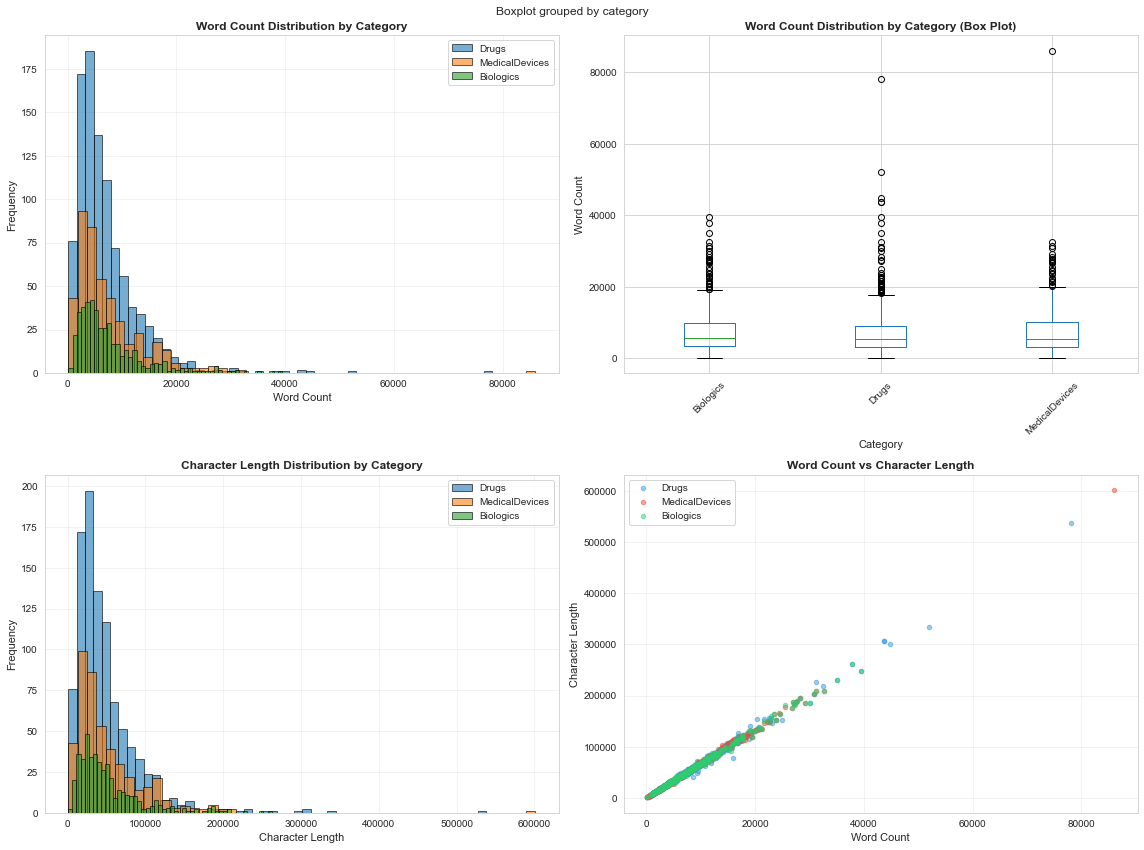


Document Length Statistics by Category:

Drugs:
  Documents: 981
  Word Count - Mean: 7128, Median: 5447
  Word Count - Min: 124, Max: 78,076
  Char Length - Mean: 48004, Median: 36671
  Char Length - Min: 923, Max: 538,144

MedicalDevices:
  Documents: 453
  Word Count - Mean: 7709, Median: 5447
  Word Count - Min: 124, Max: 86,046
  Char Length - Mean: 52037, Median: 36559
  Char Length - Min: 923, Max: 601,271

Biologics:
  Documents: 446
  Word Count - Mean: 7824, Median: 5748
  Word Count - Min: 124, Max: 39,475
  Char Length - Mean: 52622, Median: 39358
  Char Length - Min: 923, Max: 262,162


In [9]:
# Document Length Distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Word Count Distribution by Category
for category in clean_df['category'].unique():
    data = clean_df[clean_df['category'] == category]['word_count']
    axes[0, 0].hist(data, bins=50, alpha=0.6, label=category, edgecolor='black')
axes[0, 0].set_xlabel('Word Count', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Word Count Distribution by Category', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box Plot: Word Count by Category
clean_df.boxplot(column='word_count', by='category', ax=axes[0, 1])
axes[0, 1].set_title('Word Count Distribution by Category (Box Plot)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Category', fontsize=11)
axes[0, 1].set_ylabel('Word Count', fontsize=11)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Character Length Distribution
for category in clean_df['category'].unique():
    data = clean_df[clean_df['category'] == category]['char_len']
    axes[1, 0].hist(data, bins=50, alpha=0.6, label=category, edgecolor='black')
axes[1, 0].set_xlabel('Character Length', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Character Length Distribution by Category', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter Plot: Word Count vs Character Length
colors = {'Drugs': '#3498db', 'MedicalDevices': '#e74c3c', 'Biologics': '#2ecc71'}
for category in clean_df['category'].unique():
    data = clean_df[clean_df['category'] == category]
    axes[1, 1].scatter(data['word_count'], data['char_len'], 
                      alpha=0.5, label=category, color=colors.get(category, 'gray'), s=20)
axes[1, 1].set_xlabel('Word Count', fontsize=11)
axes[1, 1].set_ylabel('Character Length', fontsize=11)
axes[1, 1].set_title('Word Count vs Character Length', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'document_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics summary
print("\nDocument Length Statistics by Category:")
print("=" * 60)
for category in clean_df['category'].unique():
    cat_data = clean_df[clean_df['category'] == category]
    print(f"\n{category}:")
    print(f"  Documents: {len(cat_data):,}")
    print(f"  Word Count - Mean: {cat_data['word_count'].mean():.0f}, Median: {cat_data['word_count'].median():.0f}")
    print(f"  Word Count - Min: {cat_data['word_count'].min():,}, Max: {cat_data['word_count'].max():,}")
    print(f"  Char Length - Mean: {cat_data['char_len'].mean():.0f}, Median: {cat_data['char_len'].median():.0f}")
    print(f"  Char Length - Min: {cat_data['char_len'].min():,}, Max: {cat_data['char_len'].max():,}")


### Word Frequency Analysis

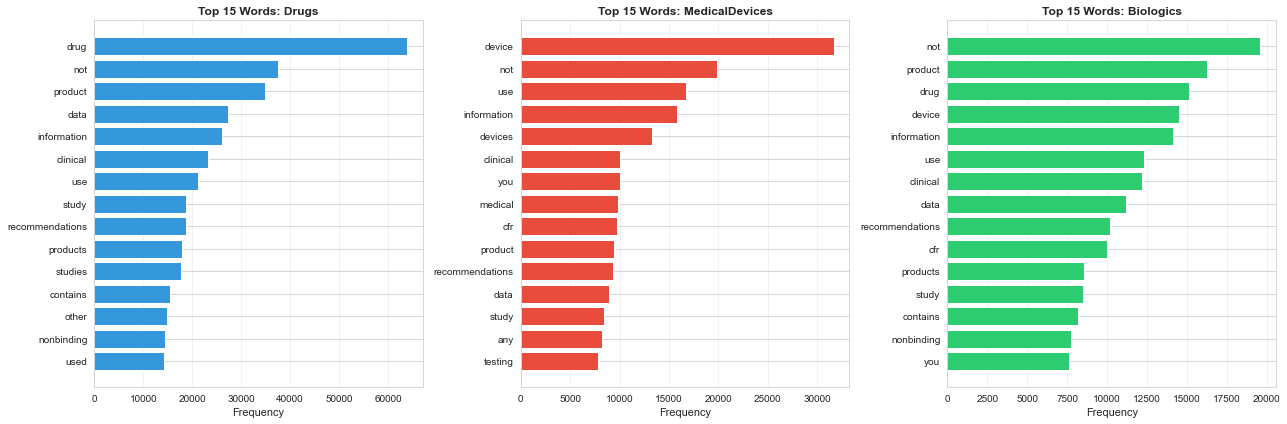


Top Words by Category:

Drugs:
  drug: 63,915
  not: 37,608
  product: 34,869
  data: 27,330
  information: 26,145
  clinical: 23,152
  use: 21,184
  study: 18,669
  recommendations: 18,649
  products: 18,008
  studies: 17,612
  contains: 15,403
  other: 14,800
  nonbinding: 14,343
  used: 14,197
  when: 13,878
  under: 13,695
  safety: 12,849
  such: 12,815
  trial: 12,788

MedicalDevices:
  device: 31,675
  not: 19,810
  use: 16,717
  information: 15,779
  devices: 13,238
  clinical: 10,016
  you: 10,000
  medical: 9,834
  cfr: 9,771
  product: 9,446
  recommendations: 9,355
  data: 8,939
  study: 8,423
  any: 8,233
  testing: 7,804
  drug: 7,473
  contains: 7,468
  test: 7,440
  used: 7,432
  nonbinding: 7,092

Biologics:
  not: 19,590
  product: 16,257
  drug: 15,114
  device: 14,485
  information: 14,116
  use: 12,294
  clinical: 12,211
  data: 11,176
  recommendations: 10,187
  cfr: 9,969
  products: 8,548
  study: 8,460
  contains: 8,181
  nonbinding: 7,752
  you: 7,645
  under

In [10]:
# Word Frequency Analysis by Category
# Common stopwords to exclude
stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
             'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
             'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
             'may', 'might', 'can', 'could', 'this', 'that', 'these', 'those',
             'from', 'as', 'if', 'it', 'its', 'they', 'them', 'their', 'there'} | \
            set(['fda', 'guidance', 'document', 'section', 'page', 'see', 'also',
                'may', 'shall', 'must', 'should', 'guidance', 'industry', 'policy'])

def extract_top_words(text_series, top_n=20, exclude_stopwords=True):
    """Extract top words from a series of texts"""
    all_words = []
    for text in text_series:
        if pd.notna(text) and isinstance(text, str):
            # Simple word tokenization (split by whitespace and punctuation)
            words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
            if exclude_stopwords:
                words = [w for w in words if w not in stopwords]
            all_words.extend(words)
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Analyze top words for each category
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

category_colors = {'Drugs': '#3498db', 'MedicalDevices': '#e74c3c', 'Biologics': '#2ecc71'}

for idx, category in enumerate(clean_df['category'].unique()):
    cat_texts = clean_df[clean_df['category'] == category]['clean_text']
    top_words = extract_top_words(cat_texts, top_n=15)
    
    words, counts = zip(*top_words) if top_words else ([], [])
    
    axes[idx].barh(range(len(words)), counts, color=category_colors.get(category, 'gray'))
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].set_xlabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Top 15 Words: {category}', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(PLOT_DIR / 'word_frequency_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

# Print word frequencies
print("\nTop Words by Category:")
print("=" * 60)
for category in clean_df['category'].unique():
    cat_texts = clean_df[clean_df['category'] == category]['clean_text']
    top_words = extract_top_words(cat_texts, top_n=20)
    print(f"\n{category}:")
    for word, count in top_words:
        print(f"  {word}: {count:,}")


### Word Cloud Visualization


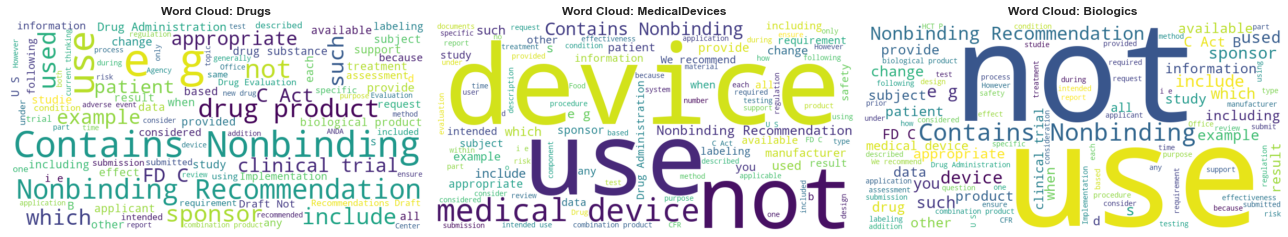

In [13]:
# Word Cloud for Each Category
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, category in enumerate(clean_df['category'].unique()):
    cat_texts = clean_df[clean_df['category'] == category]['clean_text']
    # Combine all texts for this category
    combined_text = ' '.join(cat_texts.dropna().astype(str))
    
    if len(combined_text) > 100:  # Only create word cloud if there's enough text
        # Create word cloud
        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            max_words=100,
            colormap='viridis',
            stopwords=stopwords,
            relative_scaling=0.5
        ).generate(combined_text)
        
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'Word Cloud: {category}', fontsize=12, fontweight='bold')
    else:
        axes[idx].text(0.5, 0.5, 'Insufficient text data', 
                     ha='center', va='center', fontsize=12)
        axes[idx].axis('off')
        axes[idx].set_title(f'Word Cloud: {category}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOT_DIR / 'wordclouds_by_category.png', dpi=300, bbox_inches='tight')
plt.show()


### Text Statistics Summary


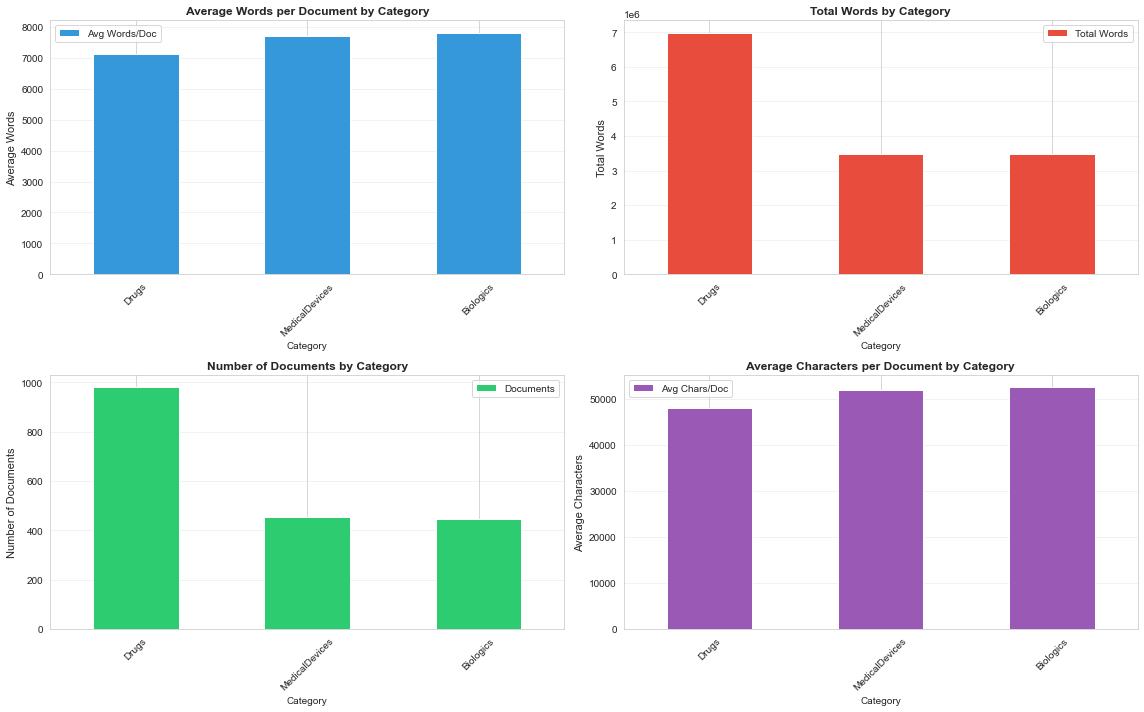


Text Statistics Summary:
      Category  Documents  Total Words  Total Characters  Avg Words/Doc  Avg Chars/Doc  Median Words  Median Chars  Min Words  Max Words  Min Chars  Max Chars
         Drugs        981      6992404          47091528    7127.832824   48003.596330        5447.0       36671.0        124      78076        923     538144
MedicalDevices        453      3492150          23572824    7708.940397   52037.139073        5447.0       36559.0        124      86046        923     601271
     Biologics        446      3489386          23469504    7823.735426   52622.206278        5748.5       39358.0        124      39475        923     262162


All visualizations saved to: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output_cleaned/visualizations


In [ ]:
# Comprehensive Text Statistics
stats_data = []

for category in clean_df['category'].unique():
    cat_data = clean_df[clean_df['category'] == category]
    stats_data.append({
        'Category': category,
        'Documents': len(cat_data),
        'Total Words': cat_data['word_count'].sum(),
        'Total Characters': cat_data['char_len'].sum(),
        'Avg Words/Doc': cat_data['word_count'].mean(),
        'Avg Chars/Doc': cat_data['char_len'].mean(),
        'Median Words': cat_data['word_count'].median(),
        'Median Chars': cat_data['char_len'].median(),
        'Min Words': cat_data['word_count'].min(),
        'Max Words': cat_data['word_count'].max(),
        'Min Chars': cat_data['char_len'].min(),
        'Max Chars': cat_data['char_len'].max(),
    })

stats_df = pd.DataFrame(stats_data)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Average Words per Document
stats_df.plot(x='Category', y='Avg Words/Doc', kind='bar', ax=axes[0, 0], color='#3498db')
axes[0, 0].set_title('Average Words per Document by Category', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Average Words', fontsize=11)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Total Words by Category
stats_df.plot(x='Category', y='Total Words', kind='bar', ax=axes[0, 1], color='#e74c3c')
axes[0, 1].set_title('Total Words by Category', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Total Words', fontsize=11)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Document Count
stats_df.plot(x='Category', y='Documents', kind='bar', ax=axes[1, 0], color='#2ecc71')
axes[1, 0].set_title('Number of Documents by Category', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Documents', fontsize=11)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Average Characters per Document
stats_df.plot(x='Category', y='Avg Chars/Doc', kind='bar', ax=axes[1, 1], color='#9b59b6')
axes[1, 1].set_title('Average Characters per Document by Category', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Average Characters', fontsize=11)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(PLOT_DIR / 'text_statistics_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics table
print("\nText Statistics Summary:")
print("=" * 80)
print(stats_df.to_string(index=False))
print("\n\nAll visualizations saved to:", PLOT_DIR)